### Final Propensity matching results

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython


In [2]:
%reload_ext Cython

In [3]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [4]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load pre matching data

In [5]:
pp_str = 'Pre_Matching_DATA/'

treated2 = pd.read_pickle(pp_str+'treated2.p')
controls = pd.read_pickle(pp_str+'controls.p')
pmpm =pd.read_pickle(pp_str+'pmpm.p')
random_controls = pd.read_pickle('tempHybridSelectionMoreData/random.p')

### Pick Columns for matching

In [6]:
#cols = list(col for col in treated2.columns if col not in ['PERS_ID', 'MYR'])
#columns_to_match = cols
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

In [7]:
%%time

propensity_func_args = {'match_on':columns_to_match, 'neighbors_per_treated': 5, 'onset': "CC_DIABETES", "onset_val" : 0}
matched0, matched_data0 = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           propensity_func, 
                                           propensity_func_args)




Mathcing Function: propensity_func
Propensity Score Matching...fitting model
Fitted: LogisticRegression
Creating Matched Set...


0it [00:00, ?it/s]

iter: 0


200it [11:39,  3.53s/it]

iter: 200


400it [23:22,  3.55s/it]

iter: 400


600it [35:05,  3.52s/it]

iter: 600


800it [46:51,  3.59s/it]

iter: 800


1000it [58:41,  3.53s/it]

iter: 1000


1200it [1:10:42,  3.60s/it]

iter: 1200


1400it [1:22:40,  3.59s/it]

iter: 1400


1565it [1:32:34,  3.55s/it]


CPU times: user 1h 5min 51s, sys: 37min 53s, total: 1h 43min 45s
Wall time: 1h 35min 29s


####  In addition to the previously created matched groups create a random group

In [38]:
Path('./tempPropSelection').mkdir(exist_ok = True)
p = './tempPropSelection/'
matched_data0.to_pickle(p+'match0.p')
treated2.to_pickle(p+'treated0.p')

In [15]:
pmpm2 = pmpm
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [16]:
from utils import statistics_first_month, p_val, stat_matrices 

### List containing all numerical columns

In [17]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

### Stats First Month(Treated and Matched Controls)

In [18]:
%%time
tr_desc0, treated_first_month = statistics_first_month(treated2, all_columns, return_array = True)
con_desc0, controls_first_month = statistics_first_month(matched_data0, all_columns, return_array = True)

CPU times: user 3.78 s, sys: 31.3 ms, total: 3.82 s
Wall time: 3.81 s


### Stats First Month(General Pop and Random)

In [19]:
%%time
pmpm_desc = statistics_first_month(pmpm2, all_columns)
random_desc = statistics_first_month(random_controls, all_columns)

CPU times: user 2min 33s, sys: 7.56 s, total: 2min 40s
Wall time: 2min 40s


In [20]:
%%time
conds_first, full_first = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)

CPU times: user 32 ms, sys: 316 µs, total: 32.3 ms
Wall time: 30.2 ms


## Statistics on matching date

In [21]:
conds_first.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   50.206           49.540   1.464  0.143             44.311   47.606
ALLOW_AMT        693.750          652.118   0.530  0.596           1065.926  648.803
MBR_GNDR           0.206            0.206  -0.004  0.997              0.443    0.431
CC_TOBACCO         0.061            0.060   0.184  0.854              0.074    0.098
CC_PRESSURE        0.001            0.005  -1.951  0.051              0.007    0.007
CC_OBESITY         0.456            0.445   0.814  0.416              0.109    0.228
CC_HYPERTENSION    0.325            0.307   1.363  0.173              0.208    0.249
CC_HYPOTHYROID     0.095            0.083   1.562  0.118              0.047    0.063
CC_DX_CNT          2.706            2.577   2.071  0.038              1.824    2.344
ACUTE2             0.039            0.024   3.042  0.002              0.063    0.052
ACUTE6             0.112            0.073   4.356  0.000              0.063    0.153
IP_BIN6            0.028            0.025   0.676  0.499              0.021    0.047
ER_BIN6            0.089            0.051   5.090  0.000              0.047    0.116
LOB                0.952            0.893   7.307  0.000              0.756    0.788

In [22]:
full_first

Treated                    Matched Controls                      Test-TC               General Population                         Test-TG                    Random                       Test-TR              
                       mean          std count             mean          std count    t-stat          pval               mean          std   count     t-stat          pval        mean          std count     t-stat          pval
AGE_AT_MIDMONTH   50.205736    12.733903  1604        49.539864    17.244376  7513  1.463606  1.433362e-01          44.310976    20.053585  356446  11.762030  6.207968e-32   47.606399    19.811819  7876   5.046484  4.583703e-07
ALLOW_AMT        693.750000  2216.211182  1604       652.118195  2977.278372  7513  0.529568  5.964242e-01        1065.926022  6933.418650  356446  -2.149328  3.160904e-02  648.802692  3166.090228  7876   0.542150  5.877276e-01
MBR_GNDR           0.205736     0.404364  1604         0.205777     0.404295  7513 -0.003686  9.970589e-01           0.442749     0.496712  356446 -19.081951  3.914644e-81    0.431056     0.495255  7876 -17.097185  1.439342e-64
CC_TOBACCO         0.061097     0.239583  1604         0.059896     0.237310  7513  0.183698  8.542548e-01           0.074202     0.262100  356446  -1.998705  4.564109e-02    0.098400     0.297874  7876  -4.714462  2.458070e-06
CC_PRESSURE        0.001247     0.035300  1604         0.004659     0.068099  7513 -1.951219  5.106155e-02           0.007390     0.085645  356446  -2.871419  4.086576e-03    0.006602     0.080991  7876  -2.598386  9.380812e-03
CC_OBESITY         0.456359     0.498247  1604         0.445228     0.497024  7513  0.813851  4.157515e-01           0.108841     0.311440  356446  44.434357  0.000000e+00    0.228035     0.419592  7876  19.209513  1.041149e-80
CC_HYPERTENSION    0.324813     0.468451  1604         0.307467     0.461475  7513  1.362923  1.729403e-01           0.207717     0.405674  356446  11.525694  9.915163e-31    0.249365     0.432673  7876   6.274847  3.652926e-10
CC_HYPOTHYROID     0.094763     0.292979  1604         0.082790     0.275583  7513  1.561803  1.183692e-01           0.047300     0.212281  356446   8.916454  4.836392e-19    0.063484     0.243847  7876   4.516264  6.370084e-06
CC_DX_CNT          2.706359     2.227360  1604         2.576601     2.289084  7513  2.070610  3.842330e-02           1.824419     2.412274  356446  14.614465  2.345498e-48    2.343702     2.439688  7876   5.504457  3.799632e-08
ACUTE2             0.038653     0.208377  1604         0.024358     0.161752  7513  3.041608  2.359872e-03           0.063258     0.243426  356446  -4.041413  5.314111e-05    0.051549     0.237733  7876  -2.020160  4.339483e-02
ACUTE6             0.111596     0.412699  1604         0.072541     0.304271  7513  4.356035  1.338890e-05           0.063258     0.243426  356446   7.901966  2.753095e-15    0.153377     0.475791  7876  -3.274968  1.060534e-03
IP_BIN6            0.028055     0.199403  1604         0.024757     0.172448  7513  0.675524  4.993599e-01           0.020587     0.141996  356446   2.097153  3.598074e-02    0.046851     0.263725  7876  -2.701482  6.915408e-03
ER_BIN6            0.088529     0.359723  1604         0.050712     0.246833  7513  5.089762  3.656706e-07           0.047286     0.212251  356446   7.732311  1.058846e-14    0.116176     0.402957  7876  -2.548765  1.082613e-02
LOB                0.951995     0.213843  1604         0.892719     0.309490  7513  7.307126  2.958789e-13           0.755775     0.429627  356446  18.281467  1.257397e-74    0.787836     0.408866  7876  15.649481  1.606802e-54

### Statistics Over all dates (treated, controls)

In [23]:
%%time
tr_desc0A = treated2[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc0A['count'] = tr_desc0A['count'].astype(int)

con_desc0A = matched_data0[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc0A['count'] = con_desc0A['count'].astype(int)

CPU times: user 731 ms, sys: 0 ns, total: 731 ms
Wall time: 730 ms


### Statistics Over all dates (general population, Random)

In [24]:
%%time
pmpm_descA = pmpm2[all_columns].describe().loc[['mean', 'std', 'count']].T
pmpm_descA['count'] = pmpm_descA['count'].astype(int)

random_descA = random_controls[all_columns].describe().loc[['mean', 'std', 'count']].T
random_descA['count'] = random_descA['count'].astype(int)

CPU times: user 29.3 s, sys: 2.2 s, total: 31.5 s
Wall time: 31.5 s


In [25]:
%%time
conds, full = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols, full_AllCols = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = all_columns)

CPU times: user 29.1 ms, sys: 1.02 ms, total: 30.1 ms
Wall time: 28.4 ms


In [26]:
conds.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   50.837           51.253  -3.716  0.000             50.379   50.236
ALLOW_AMT        782.435          789.579  -0.236  0.814            857.856  706.609
MBR_GNDR           0.189            0.196  -2.269  0.023              0.433    0.429
CC_TOBACCO         0.063            0.065  -0.742  0.458              0.102    0.100
CC_PRESSURE        0.002            0.005  -5.614  0.000              0.013    0.008
CC_OBESITY         0.505            0.473   9.268  0.000              0.255    0.286
CC_HYPERTENSION    0.325            0.334  -2.622  0.009              0.329    0.300
CC_HYPOTHYROID     0.095            0.096  -0.292  0.771              0.078    0.075
CC_DX_CNT          2.918            2.912   0.340  0.734              2.955    2.759
ACUTE2             0.032            0.036  -3.293  0.001              0.060    0.050
ACUTE6             0.100            0.104  -1.702  0.089              0.168    0.150
IP_BIN6            0.025            0.034  -6.850  0.000              0.055    0.049
ER_BIN6            0.079            0.074   2.364  0.018              0.122    0.111
LOB                0.953            0.895  28.832  0.000              0.802    0.803

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Matrices and Figures for the paper

In [27]:
columns_to_match

['AGE_AT_MIDMONTH',
 'ALLOW_AMT',
 'MBR_GNDR',
 'CC_TOBACCO',
 'CC_PRESSURE',
 'CC_OBESITY',
 'CC_HYPERTENSION',
 'CC_HYPOTHYROID',
 'CC_DX_CNT',
 'ACUTE2',
 'ACUTE6',
 'IP_BIN6',
 'ER_BIN6',
 'LOB']

In [28]:
mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                                     'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                                      'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness']))
mapping2 = dict(zip(all_columns, all_columns))
#mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [29]:
base_path = './results/propensity_selection/'
p = Path(base_path)
p.mkdir(parents = True, exist_ok = True)

In [30]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

In [31]:
from diabetes_onset_plotter import plot_hist, save_arrays, save_arrays2


#### remove %%capture to see output

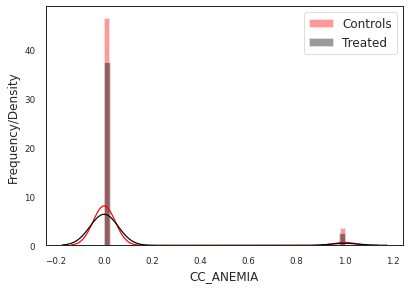

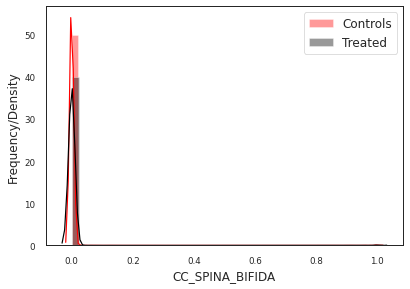

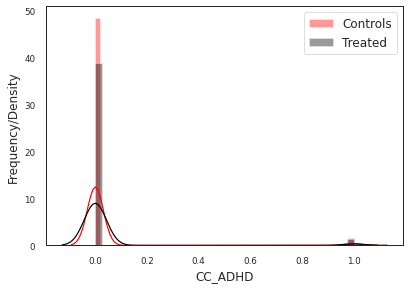

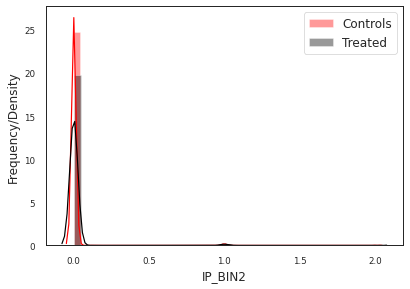

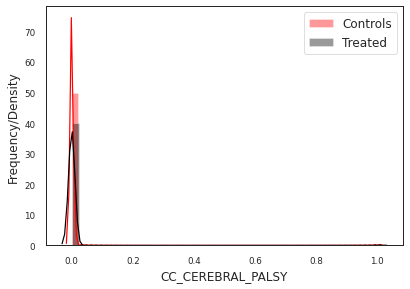

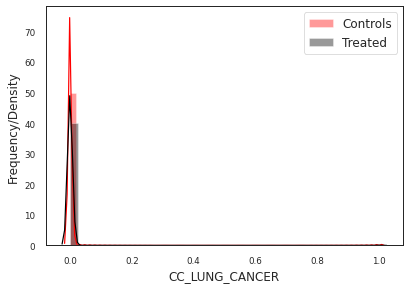

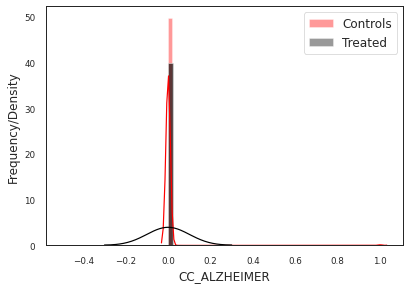

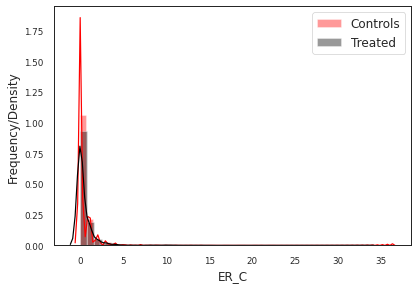

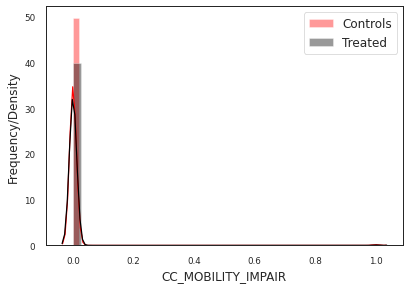

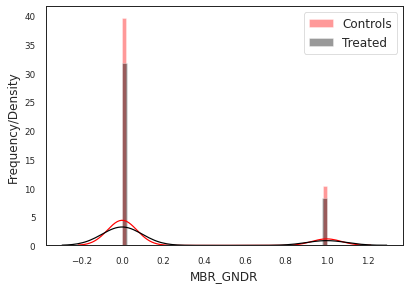

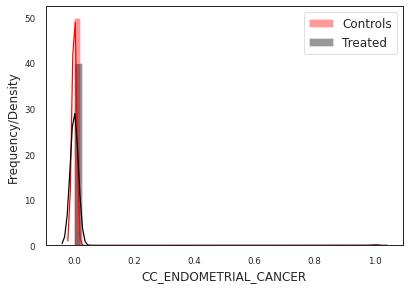

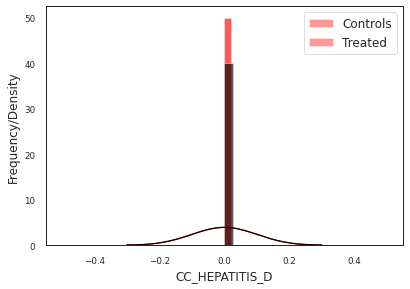

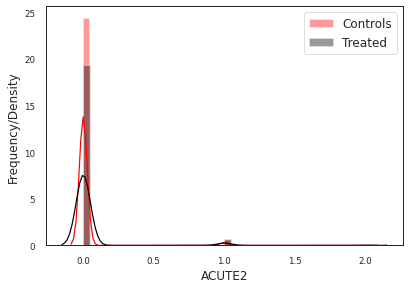

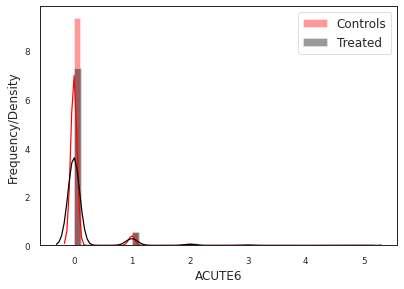

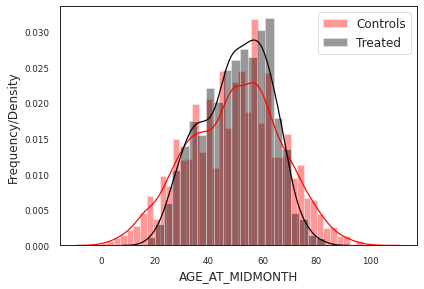

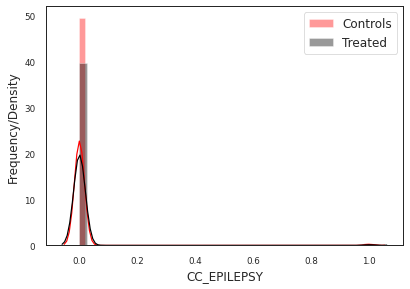

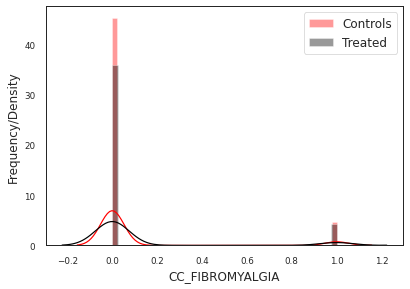

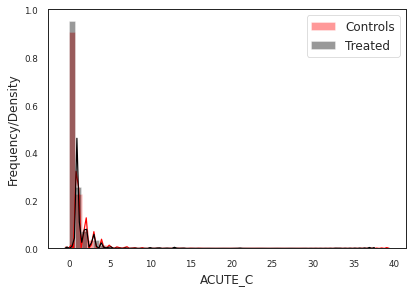

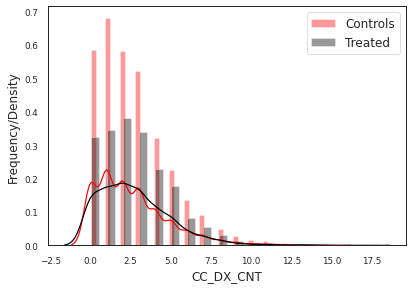

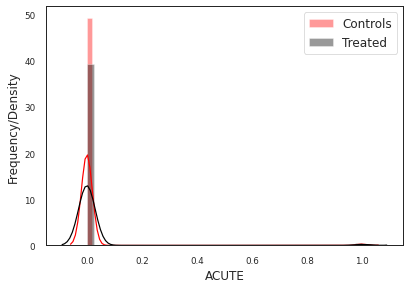

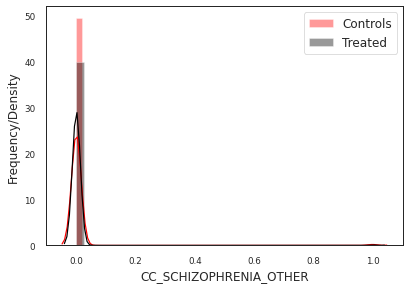

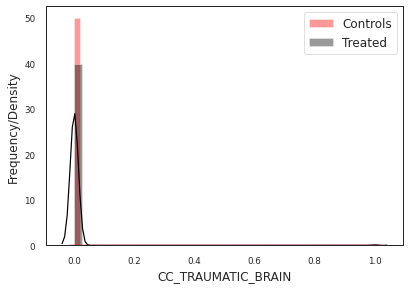

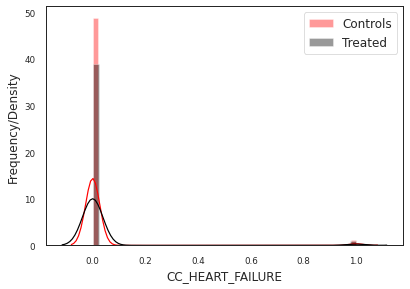

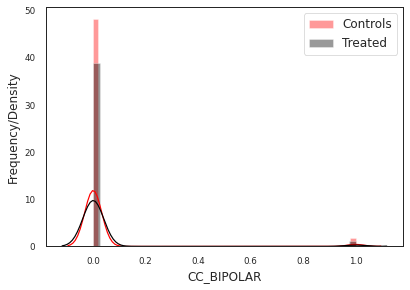

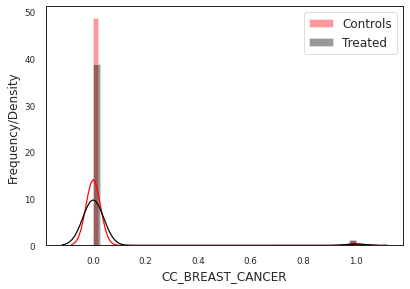

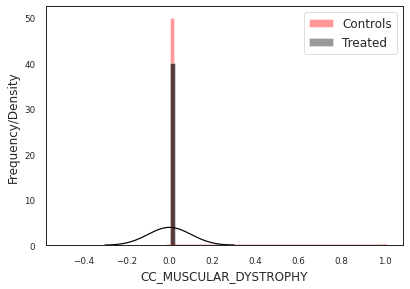

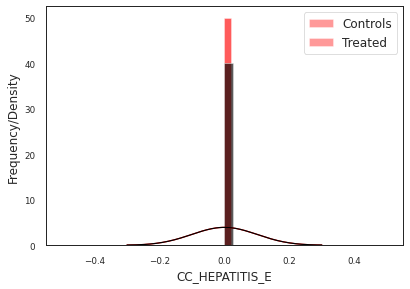

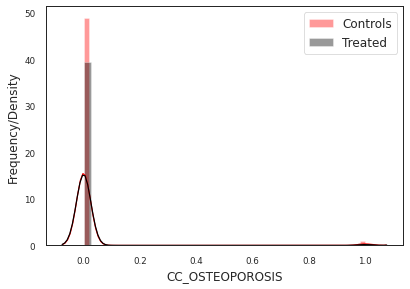

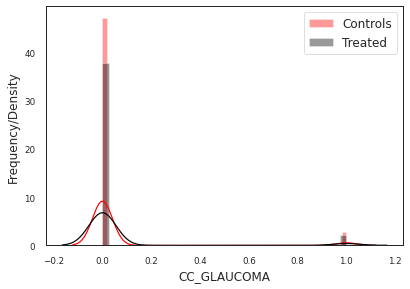

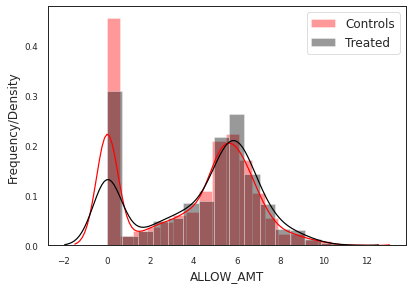

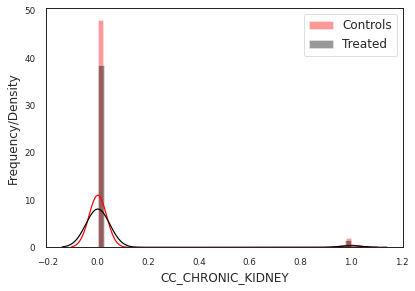

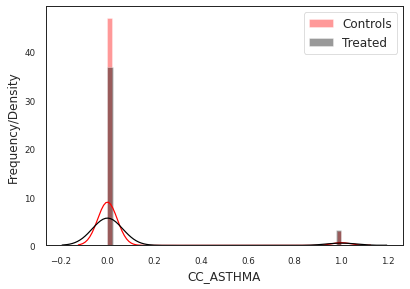

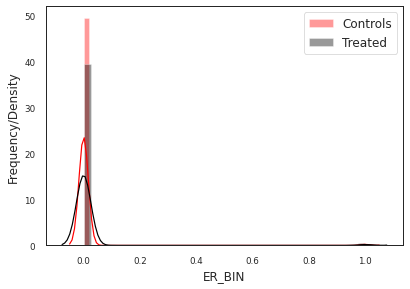

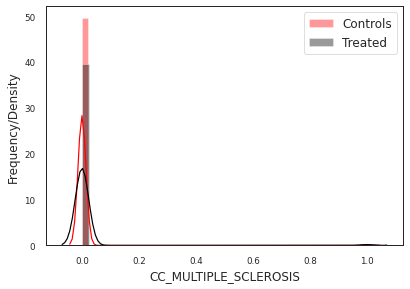

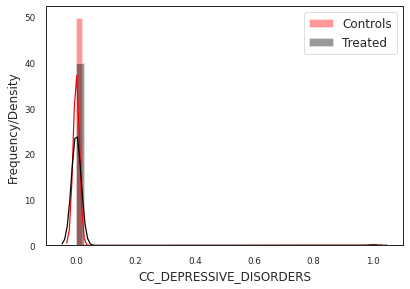

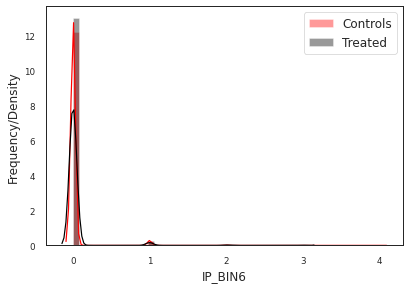

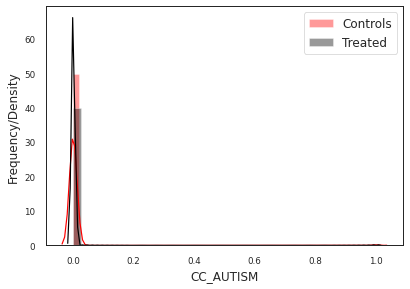

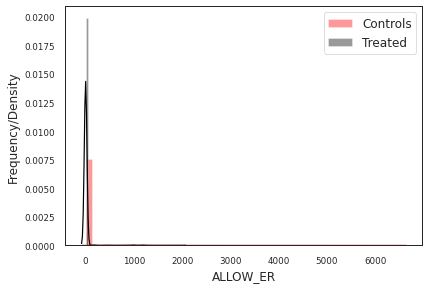

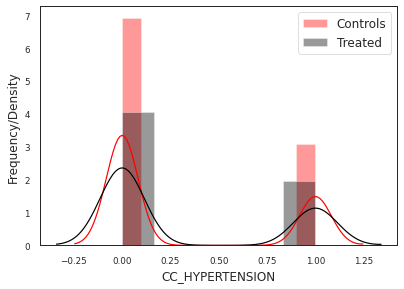

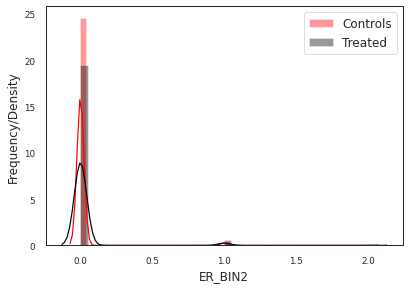

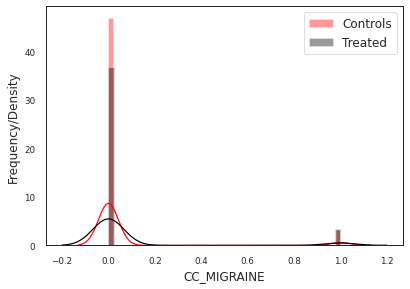

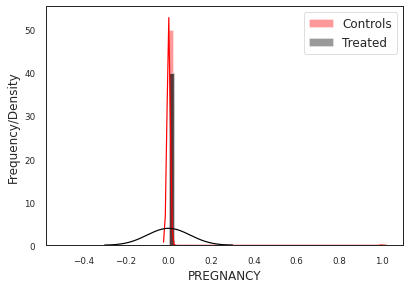

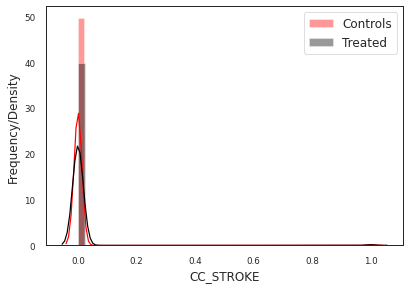

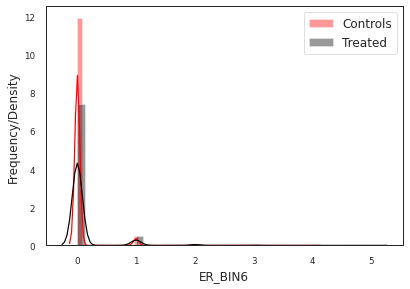

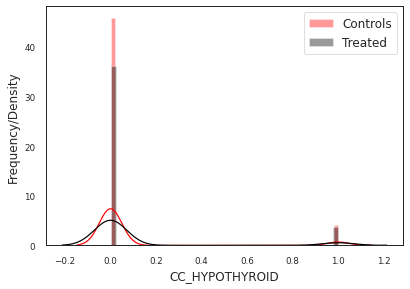

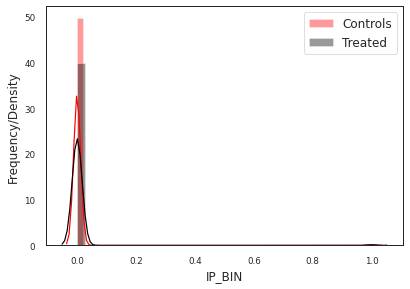

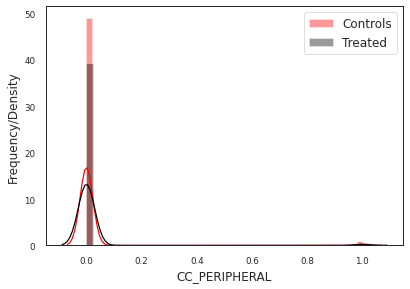

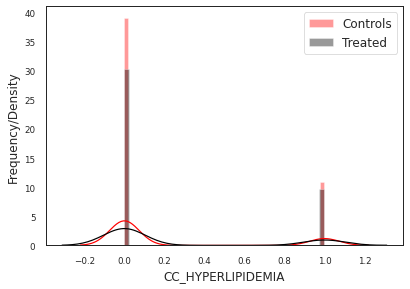

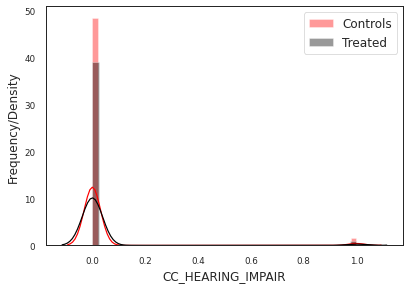

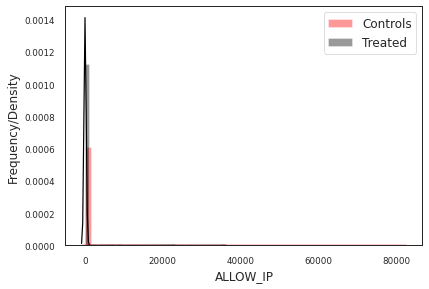

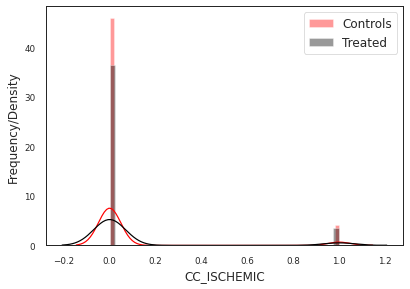

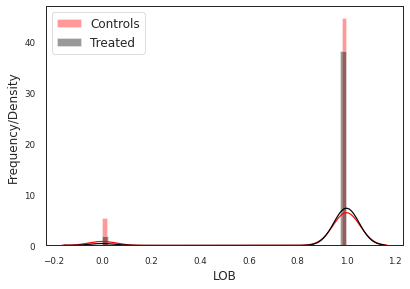

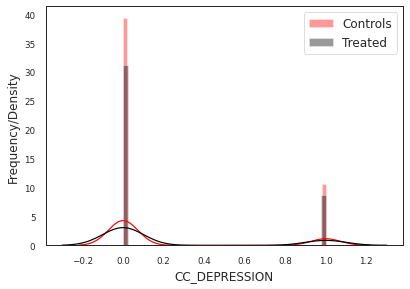

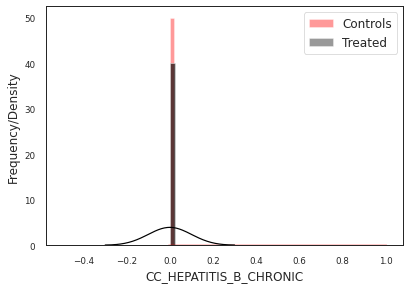

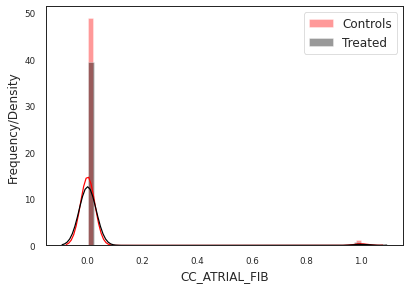

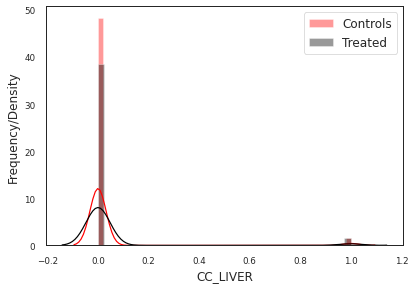

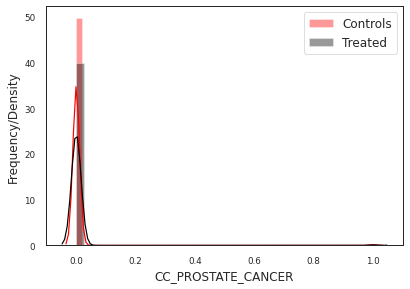

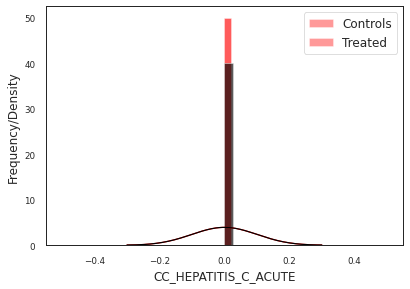

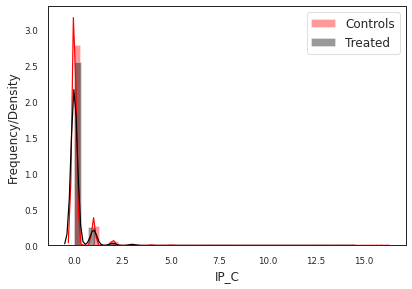

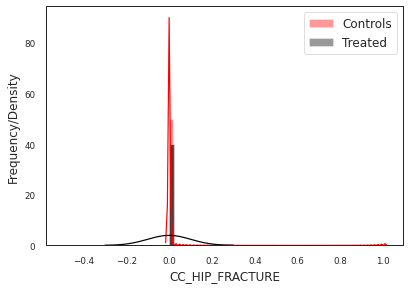

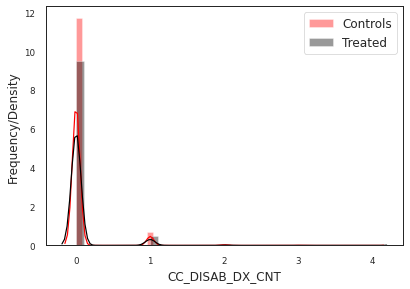

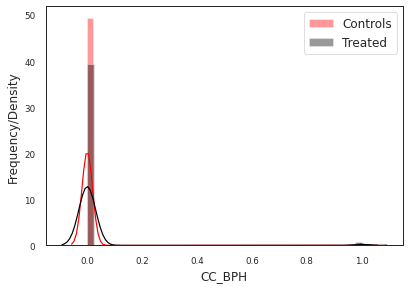

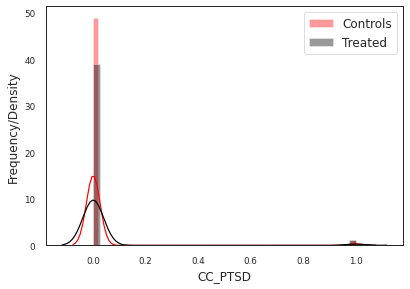

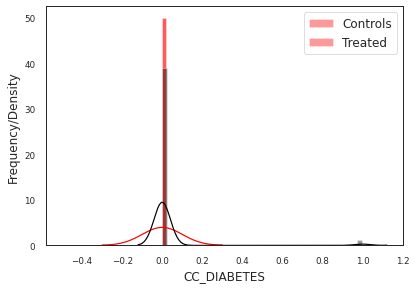

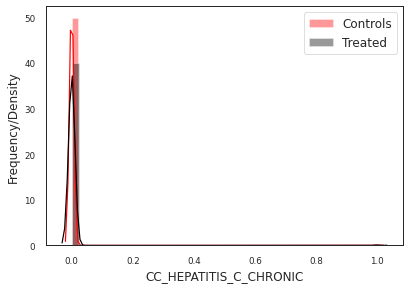

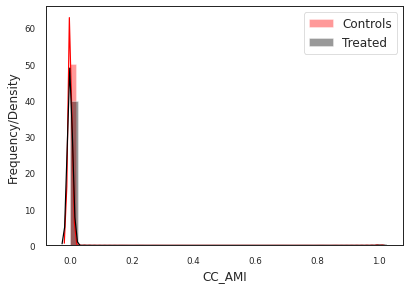

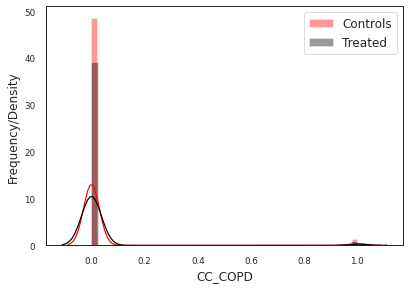

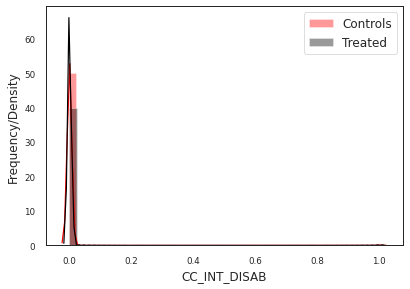

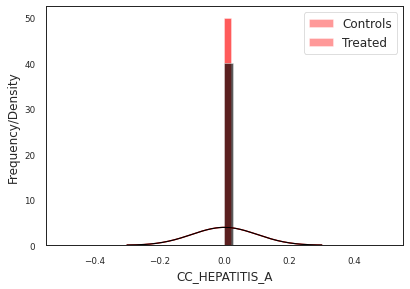

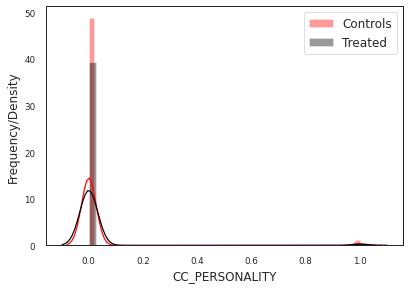

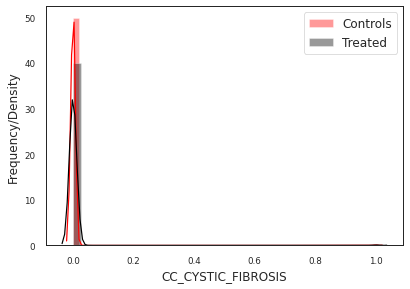

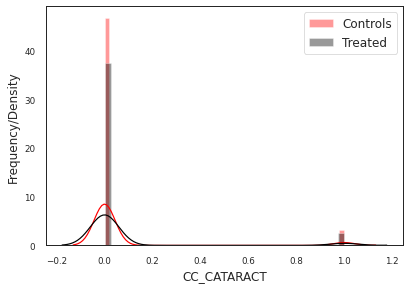

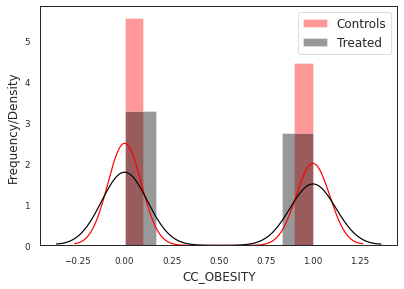

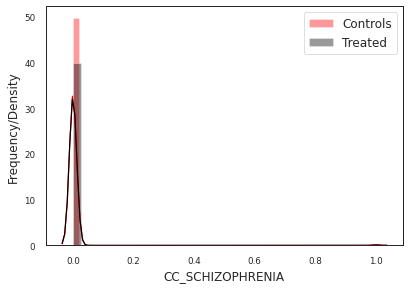

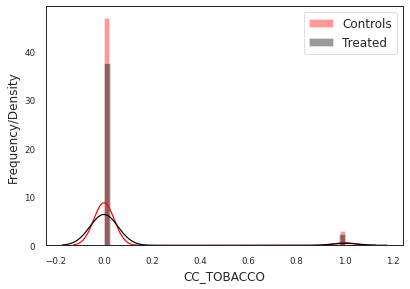

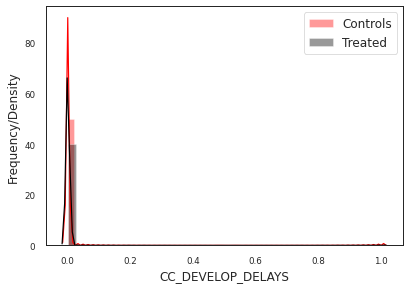

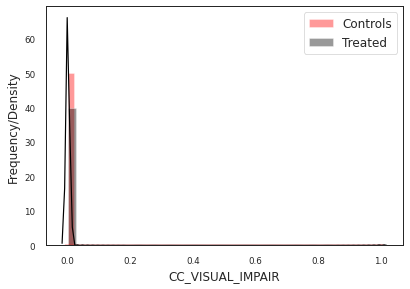

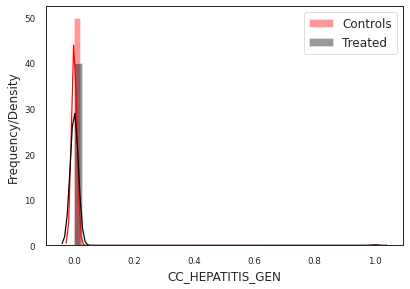

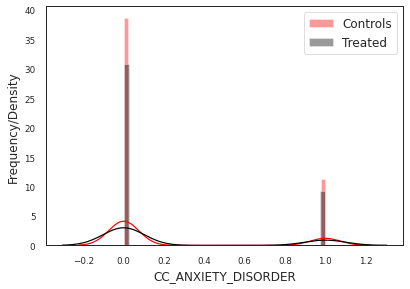

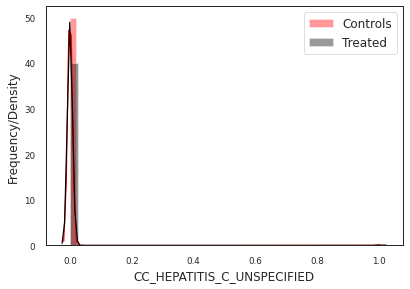

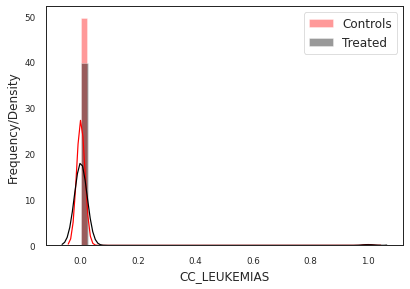

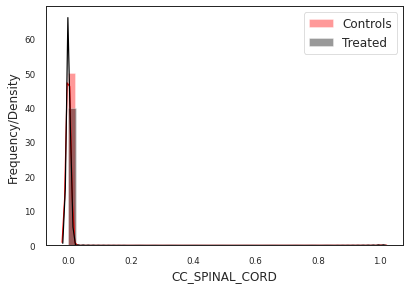

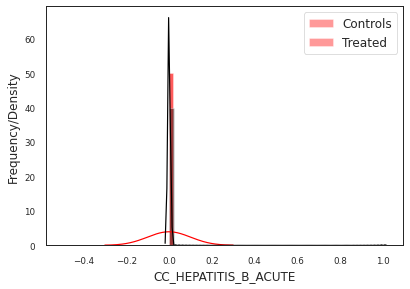

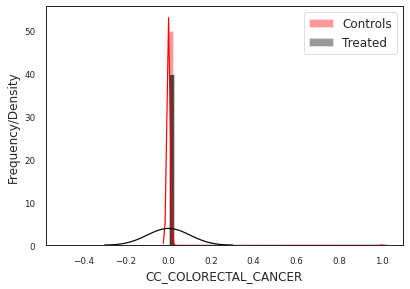

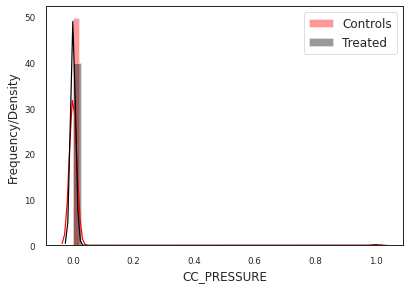

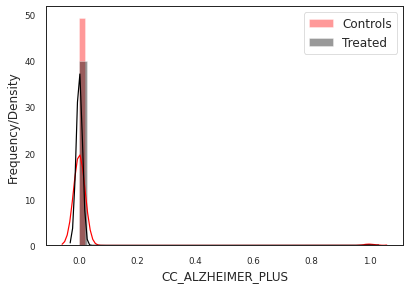

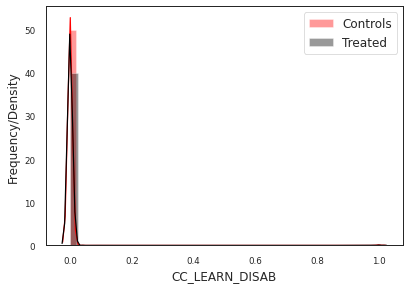

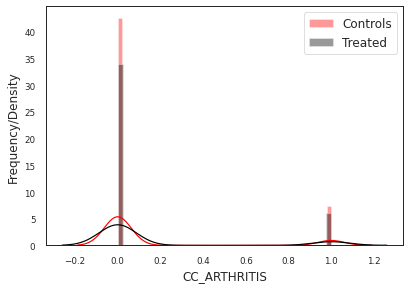

In [35]:
#%%capture

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_all/',
                dist_plot_args = dist_plot_args)

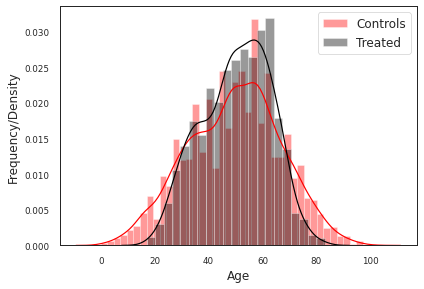

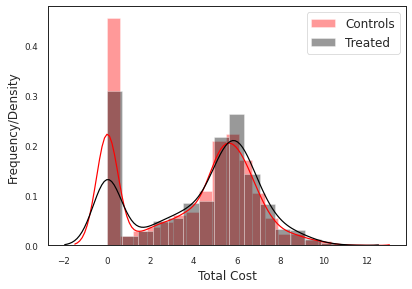

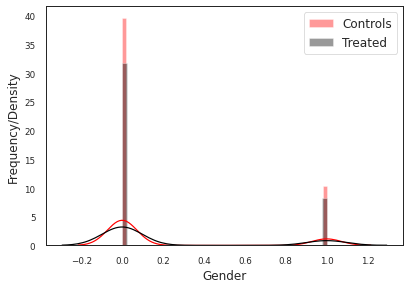

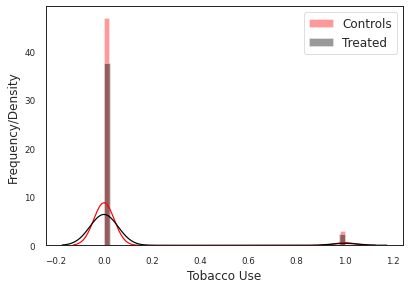

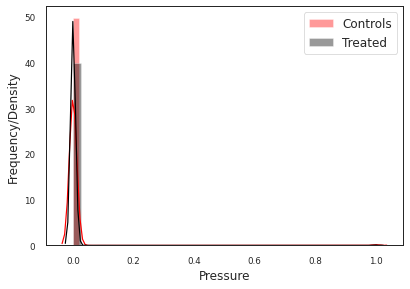

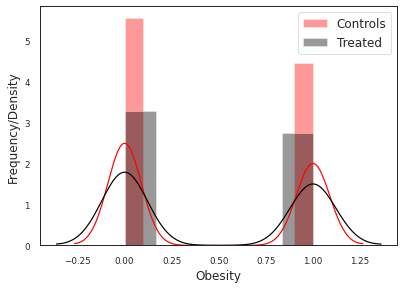

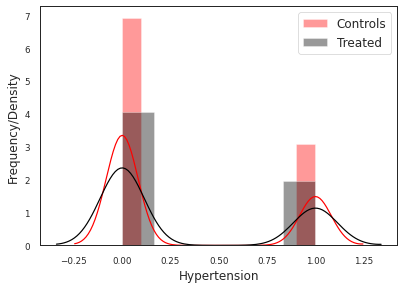

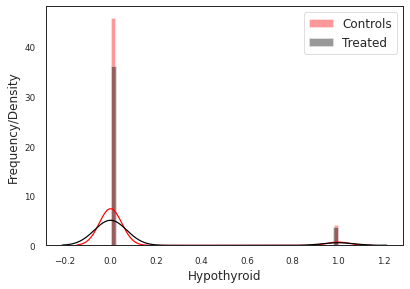

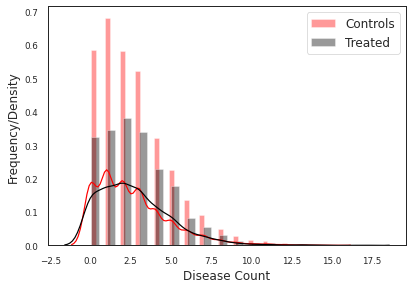

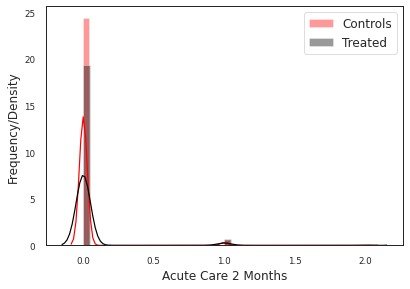

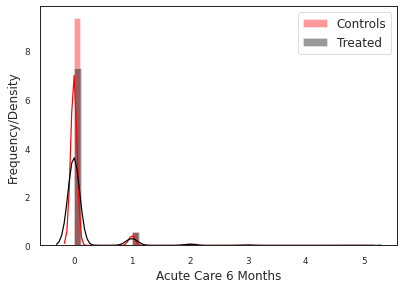

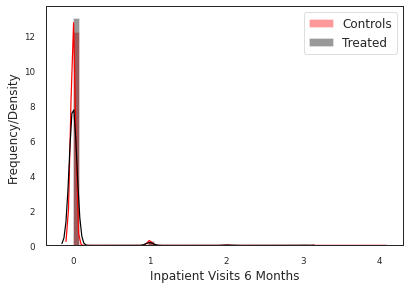

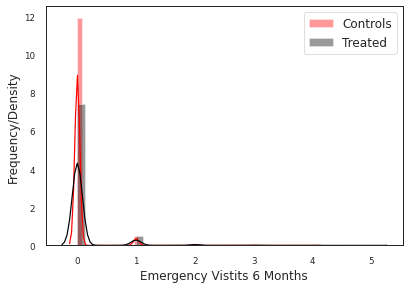

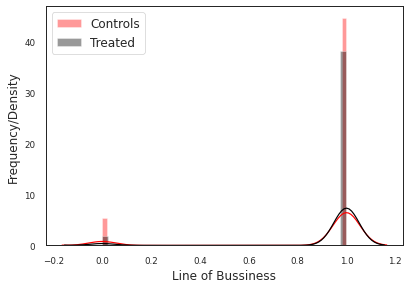

In [36]:
#%%capture
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_selection/',
                dist_plot_args = dist_plot_args)

### Save enhanced stats arrays(these will be used at the end)
Arrays with: Statistics in first day, statistics  in the span of monthsm statistiocs from selected columns and all columns

In [37]:
arrays = [conds_first, full_first, conds_firstAllCols, full_firstAllCols,
         conds, full, conds_AllCols, full_AllCols]
names = ['conds_first', 'full_first', 'conds_firstAllCols', 'full_firstAllCols',
         'conds', 'full', 'conds_AllCols', 'full_AllCols']
save_arrays2(arrays, names, base_path+'tables/stats/')